In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup flow and head boundary with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.boundaries.Boundary import FlowAndHeadBoundary
from morpheus.project.types.boundaries.FlowAndHeadObservation import ObservationId, FlowAndHeadRawDataItem, \
  FlowAndHeadObservation, Flow, Head, StartDateTime

head_and_flow_east = FlowAndHeadBoundary.from_geometry(
  name=BoundaryName('flow_and_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          flow=Flow.from_float(100),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
          flow=Flow.from_float(110),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          flow=Flow.from_float(140),
          head=None
        ),
      ]
    ),
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.964)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          flow=Flow.from_float(200),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 2, 1)),
          flow=Flow.from_float(210),
          head=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          flow=Flow.from_float(240),
          head=None
        ),
      ]
    ),
  ]
)

head_and_flow_west = FlowAndHeadBoundary.from_geometry(
  name=BoundaryName('flow_and_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          head=Head.from_float(300),
          flow=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=Head.from_float(300),
          flow=None
        ),
      ]
    ),
    FlowAndHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96401)),
      data=[
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
          head=Head.from_float(400),
          flow=None
        ),
        FlowAndHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          head=Head.from_float(400),
          flow=None
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(head_and_flow_west)
boundary_collection.add_boundary(head_and_flow_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(head_and_flow_east.as_geojson()))
m.add_child(folium.GeoJson(head_and_flow_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in head_and_flow_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(head_and_flow_west.as_geojson()))
m.add_child(folium.GeoJson(head_and_flow_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in head_and_flow_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [7]:
from morpheus.project.types.boundaries.Boundary import BoundaryType

len(model.boundaries.get_boundaries_of_type(BoundaryType.flow_and_head()))

2

In [8]:
head_and_flow_east.observations

[FlowAndHeadObservation(observation_id=ObservationId(value='f3de3f0c-cd42-4d0c-941d-3986ee459511'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.966), type='Point'), data=[FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=100), head=None), FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=110), head=None), FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetime(2021, 12, 31, 0, 0, tzinfo=datetime.timezone.utc)), flow=Flow(value=140), head=None)]),
 FlowAndHeadObservation(observation_id=ObservationId(value='59f7ec91-a6ef-4e7c-bca8-315159e24211'), observation_name=ObservationName(value='Observation Point 1'), geometry=Point(coordinates=(13.92499, 50.964), type='Point'), data=[FlowAndHeadRawDataItem(date_time=StartDateTime(value=datetime.datetim

In [9]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.FhbPackageMapper import \
  calculate_fhb_boundary_stress_period_data

result = calculate_fhb_boundary_stress_period_data(model)
result.to_dict()

{'date_times': [StartDateTime(value=datetime.datetime(2020, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)),
  StartDateTime(value=datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc))],
 'total_times': [0.0, 31.0],
 'flow_data': [TimeStepValuesItem(layer=0, row=0, column=99, values=[100.99997868936319, 110.99997868936319]),
  TimeStepValuesItem(layer=0, row=1, column=99, values=[102.99993735985626, 112.99993735985626]),
  TimeStepValuesItem(layer=0, row=2, column=99, values=[104.99989775163911, 114.99989775163911]),
  TimeStepValuesItem(layer=0, row=3, column=99, values=[106.99985986577755, 116.99985986577755]),
  TimeStepValuesItem(layer=0, row=4, column=99, values=[108.99982370191631, 118.99982370191631]),
  TimeStepValuesItem(layer=0, row=5, column=99, values=[110.9997892600554, 120.9997892600554]),
  TimeStepValuesItem(layer=0, row=6, column=99, values=[112.99975654055007, 122.99975654055007]),
  TimeStepValuesItem(layer=0, row=7, column=99, values=[114.99972554268979, 124

## Calculate

In [10]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [11]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='d760e92d-fb32-43e7-a1f4-de2fd20d0ca3')

In [12]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='b17df3d8-9d9c-4752-8a4d-66c815df1154'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(13.92, 50.964), (13.92, 50.966), (13.925, 50.966), (13.925, 50.964), (13.92, 50.964)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659


                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: b17df3d8-9d9c-4752-8a4d-66c815df1154.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/05/15 18:01:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/15 18:01:05
 Elapsed run time:  0.023 Seconds

  Normal termination of simulation


In [13]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['b17df3d8-9d9c-4752-8a4d-66c815df1154.pcg', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.hds', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.fhb', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.oc', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.dis', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.bas', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.nam', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.list', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.lpf'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [14]:
head = calculation_service.read_head(0, 0)

In [15]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[300.5050048828125, 422.0780029296875, 542.9420166015625, 663.3499755859375, 783.4310302734375, 903.260009765625, 1022.885009765625, 1142.3380126953125, 1261.6409912109375, 1380.81201171875, 1499.864013671875, 1618.8070068359375, 1737.6490478515625, 1856.39697265625, 1975.0570068359375, 2093.633056640625, 2212.1279296875, 2330.5458984375, 2448.889892578125, 2567.159912109375, 2685.360107421875, 2803.489013671875, 2921.550048828125, 3039.5419921875, 3157.466064453125, 3275.322998046875, 3393.112060546875, 3510.83203125, 3628.48291015625, 3746.06396484375, 3863.573974609375, 3981.011962890625, 4098.376953125, 4215.666015625, 4332.8798828125, 4450.01220703125, 4567.06494140625, 4684.0341796875, 4800.916015625, 4917.7080078125, 5034.408203125, 5151.01318359375, 5267.51806640625, 5383.919921875, 5500.21484375, 5616.39794921875, 5732.4638671875, 5848.4091796875, 5964.22802734375, 6079.9140625, 6195.4619140625, 6310.8662109375, 6426.119140625, 6541.2138671875, 6656.14404296875, 6770.9008789

In [16]:
calculation_service.read_drawdown(0, 0)

[]

In [17]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'SPECIFIED_FLOWS_IN': 2737493.5,
 'TOTAL_IN': 2737493.5,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -2737493.5,
 'SPECIFIED_FLOWS_OUT': -0.0,
 'TOTAL_OUT': -2737493.5,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'SPECIFIED_FLOWS_IN': 7499.982,
 'TOTAL_IN': 7499.982,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -7499.982,
 'SPECIFIED_FLOWS_OUT': -0.0,
 'TOTAL_OUT': -7499.982,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [19]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['b17df3d8-9d9c-4752-8a4d-66c815df1154.pcg', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.hds', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.fhb', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.oc', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.dis', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.bas', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.nam', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.list', 'b17df3d8-9d9c-4752-8a4d-66c815df1154.lpf'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


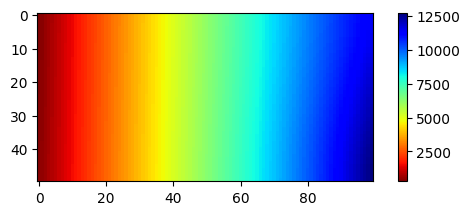

In [20]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()